# Поиск изображений по запросу

Задача заключается в разработке демонстрационной версии поиска изображений по запросу.

Для демонстрационной версии необходимо обучить модель, которая получит векторное представление изображения, векторное представление текста, а на выходе выдаст число от 0 до 1 — покажет, насколько текст и картинка подходят друг другу.

***Описание данных***

Данные лежат в папке `/datasets/image_search/`.

В файле `train_dataset.csv` находится информация, необходимая для обучения: имя файла изображения, идентификатор описания и текст описания. Для одной картинки может быть доступно до 5 описаний. Идентификатор описания имеет формат `<имя файла изображения>#<порядковый номер описания>`.

В папке `train_images` содержатся изображения для тренировки модели.

В файле `CrowdAnnotations.tsv` — данные по соответствию изображения и описания, полученные с помощью краудсорсинга. Номера колонок и соответствующий тип данных:

1. Имя файла изображения.
2. Идентификатор описания.
3. Доля людей, подтвердивших, что описание соответствует изображению.
4. Количество человек, подтвердивших, что описание соответствует изображению.
5. Количество человек, подтвердивших, что описание не соответствует изображению.

В файле `ExpertAnnotations.tsv` содержатся данные по соответствию изображения и описания, полученные в результате опроса экспертов. Номера колонок и соответствующий тип данных:

1. Имя файла изображения.
2. Идентификатор описания.

3, 4, 5 — оценки трёх экспертов.

Эксперты ставят оценки по шкале от 1 до 4, где 1 — изображение и запрос совершенно не соответствуют друг другу, 2 — запрос содержит элементы описания изображения, но в целом запрос тексту не соответствует, 3 — запрос и текст соответствуют с точностью до некоторых деталей, 4 — запрос и текст соответствуют полностью.

В файле `test_queries.csv` находится информация, необходимая для тестирования: идентификатор запроса, текст запроса и релевантное изображение. Для одной картинки может быть доступно до 5 описаний. Идентификатор описания имеет формат `<имя файла изображения>#<порядковый номер описания>`.

В папке `test_images` содержатся изображения для тестирования модели.


## Исследовательский анализ данных

In [1]:
#pip install sentence-transformers

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import re

from sklearn.model_selection import GroupShuffleSplit

from sklearn.metrics import mean_squared_error

from PIL import Image

import tensorflow as tf
from tokenizers import Tokenizer
import transformers as ppb
from tqdm import tqdm, notebook
tqdm.pandas()

from tensorflow.keras.applications.resnet import (
    ResNet50,
    decode_predictions,
    preprocess_input,
)
from tensorflow.keras.layers import Dense, Dropout, Flatten, GlobalAveragePooling2D, Activation
from tensorflow.keras.models import Sequential

from tensorflow.keras.preprocessing import image 
from tensorflow.keras.optimizers import Adam, SGD

from transformers import BertTokenizer, TFBertModel

from os.path import join
from sentence_transformers import SentenceTransformer, util

import warnings
warnings.filterwarnings('ignore')

In [3]:
SEED = 42

Зададим путь для загрузки данных

In [4]:
path = './datasets/'
train_path = join(path, 'train_images')
test_path = join(path, 'test_images')

In [5]:
class style:
    BOLD = '\033[1m'
    END = '\033[0m'

### Тренировочные данные

In [6]:
train_df = pd.read_csv(join(path, 'train_dataset.csv'))

In [7]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5822 entries, 0 to 5821
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image       5822 non-null   object
 1   query_id    5822 non-null   object
 2   query_text  5822 non-null   object
dtypes: object(3)
memory usage: 136.6+ KB


In [8]:
train_df.head().style.set_properties(subset=['query_text'],**{'text-align': 'left'})

In [9]:
train_df.describe().loc[['count', 'unique']]

image query_id query_text
count   5822     5822       5822
unique  1000      977        977

* Кол-во уникальных изображений - 1000, кол-во уникальных описаний - 977

***Вывод***
* `query_id` содержит в себе имя изображения. И похоже что описание с query_id содержащим имя изображения соответствует этому изображению. Используем данную информацию для чистки данных.

#### Проверка данных

В некоторых странах, где работает компания, действуют ограничения по обработке изображений: поисковым сервисам и сервисам, предоставляющим возможность поиска, запрещено без разрешения родителей или законных представителей предоставлять любую информацию, в том числе, но не исключительно тексты, изображения, видео и аудио, содержащие описание, изображение или запись голоса детей. Ребёнком считается любой человек, не достигший 16 лет.

Удалим все изображения, которые нарушают данный закон.

In [10]:
white_list = train_df[['query_id', 'query_text']]
white_list = white_list.drop_duplicates().reset_index(drop=True)

In [11]:
white_list.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 977 entries, 0 to 976
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   query_id    977 non-null    object
 1   query_text  977 non-null    object
dtypes: object(2)
memory usage: 15.4+ KB


In [12]:
white_list.head()

query_id  \
0  2549968784_39bfbe44f9.jpg#2   
1  2718495608_d8533e3ac5.jpg#2   
2  3181701312_70a379ab6e.jpg#2   
3  3207358897_bfa61fa3c6.jpg#2   
4  3286822339_5535af6b93.jpg#2   

                                          query_text  
0  A young child is wearing blue goggles and sitt...  
1  A girl wearing a yellow shirt and sunglasses s...  
2    A man sleeps under a blanket on a city street .  
3  A woman plays with long red ribbons in an empt...  
4         Chinese market street in the winter time .

Функция очистки текста

In [13]:
def clear(text):
    return re.sub(r"[^'a-zA-Z ]", ' ', text).lower()

Список запрещённых слов

In [14]:
child_stop = [
    "boy",
    "girl",
    "child",
    "baby",
    "kid",
    "babe",
    "infant",
    "teenager",
    "teeny",
    "juvenile",
    "teener",
    "stripling",
    "toddler",
    "youth",
    "young"
]

Функция поиска запрещённых слов

In [15]:
def check_stop(text):
    for word in child_stop:
        if word in text:
            return True
    return False

Функция для добавления колонки с именем изображения 

In [16]:
def image_name(text):
    return text.split('#')[0]   

Функция для создания белого списка, из разрешенных законом описаний и изображений

In [17]:
def censorship_train(df):
    df.columns = ['id', 'text']
    df['text'] = df['text'].apply(lambda x: clear(x))
    df['child'] = df['text'].apply(lambda x: check_stop(x))
    df = df[df['child'] == False]
    df = df.drop('child', axis=1).reset_index(drop=True)
    df['image_name'] = df['id'].apply(lambda x: image_name(x))
    return df   

In [18]:
white_list = censorship_train(white_list)

In [19]:
white_list.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 671 entries, 0 to 670
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   id          671 non-null    object
 1   text        671 non-null    object
 2   image_name  671 non-null    object
dtypes: object(3)
memory usage: 15.9+ KB


In [20]:
white_list.head()

id  \
0  3181701312_70a379ab6e.jpg#2   
1  3207358897_bfa61fa3c6.jpg#2   
2  3286822339_5535af6b93.jpg#2   
3  3360930596_1e75164ce6.jpg#2   
4   434792818_56375e203f.jpg#2   

                                                text  \
0    a man sleeps under a blanket on a city street     
1  a woman plays with long red ribbons in an empt...   
2         chinese market street in the winter time     
3  a soccer ball is above the head of a man weari...   
4  a man and woman look back at the camera while ...   

                  image_name  
0  3181701312_70a379ab6e.jpg  
1  3207358897_bfa61fa3c6.jpg  
2  3286822339_5535af6b93.jpg  
3  3360930596_1e75164ce6.jpg  
4   434792818_56375e203f.jpg

In [21]:
white_list.describe().loc[['count', 'unique']]

id text image_name
count   671  671        671
unique  671  671        671

* Осталось 671 уникальное описание

Создадим словарь с уникальными описаниями

In [22]:
text = dict(zip(white_list['id'], white_list['text']))

### Оценки экспертов

In [23]:
col_expert = ['image', 'query_id', '1', '2', '3']

In [24]:
expert_df = pd.read_csv(
    join(path, 'ExpertAnnotations.tsv'),
    sep='\t', names=col_expert, header=None
)

Функция для удаления запрещённоых законом данных

In [25]:
def del_content(df, white_list):
    return df[(
               df['image'].isin(white_list['image_name']) &
               df['query_id'].isin(white_list['id'])
             )]
    

In [26]:
expert_df = del_content(expert_df, white_list)

In [27]:
expert_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2950 entries, 2 to 5821
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   image     2950 non-null   object
 1   query_id  2950 non-null   object
 2   1         2950 non-null   int64 
 3   2         2950 non-null   int64 
 4   3         2950 non-null   int64 
dtypes: int64(3), object(2)
memory usage: 138.3+ KB


In [28]:
expert_df.head()

image                     query_id  1  2  3
2  1056338697_4f7d7ce270.jpg  3181701312_70a379ab6e.jpg#2  1  1  2
3  1056338697_4f7d7ce270.jpg  3207358897_bfa61fa3c6.jpg#2  1  2  2
4  1056338697_4f7d7ce270.jpg  3286822339_5535af6b93.jpg#2  1  1  2
5  1056338697_4f7d7ce270.jpg  3360930596_1e75164ce6.jpg#2  1  1  1
7  1056338697_4f7d7ce270.jpg   434792818_56375e203f.jpg#2  1  1  2

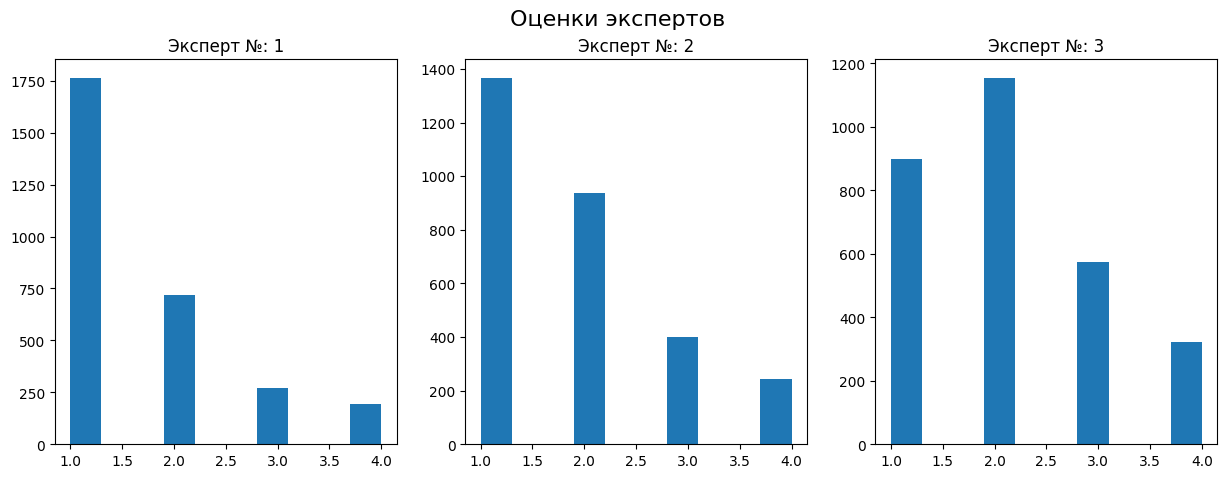

In [29]:
fig = plt.figure(figsize=(15,5))
plt.suptitle('Оценки экспертов', fontsize=16)
for i in range(3):
    fig.add_subplot(1, 3, i+1)
    plt.hist(expert_df[str(i+1)])
    plt.title(f'Эксперт №: {i+1}', fontsize=12)

* Третий эксперт чаще всего ставит оценку 2 - ~1200 раз, вероятно он более внимательно всматривается в мелкие детали и находит на изображение что-то схожее с описанием, а первый эксперт чаще остальных ставит оценку 1 - ~1750 раз, похоже что он более строго относится к показателям схожести изображений или тратит меньше времени на сравнение изображений и описаний, у второго эксперта средние показатели относительно первого и третьего эксперта (оценка 1 - ~1400 раз, оценка 2 - 900 раз.).
* Первый эксперт реже остальных ставит оценки - 3 и 4, а третий эксперт чаще остальных. Видимо эксперты по разному подходят к точности соответствия, отсюда и разные оценки;
* Эксперты гораздо чаще ставят оценки 1 и 2, чем 3 и 4 - это показатель того что верных соотвествий гораздо меньше;
* Необходимо произвести усреднение оценок, чтобы получить более точный результат целевой метрики.

Заменим номера оценок, на вероятности

In [30]:
expert_df.iloc[:, 2:] = expert_df.iloc[:, 2:].add(-1).div(3)

In [31]:
expert_df.iloc[:, :2].describe().loc[['count', 'unique']]

image query_id
count   2950     2950
unique   667      641

* Кол-во уникальных изображений - 667, кол-во уникальных описаний - 641

In [32]:
expert_df.describe().loc[['mean']]

1         2         3
mean  0.208927  0.278983  0.369718

* Первый эксперт ставит самые низкие оценки, а третий самые высокие.

Функция для получения общей оценки от экспертов

In [33]:
def expert(df):    
    if df['1'] == df['2'] or df['1'] == df['3']:
        return df['1']
   
    elif df['2'] == df['3']:
        return df['2']
        
    return None

In [34]:
expert_df['estimation_expert'] = expert_df.apply(expert, axis=1)

In [35]:
expert_df.head()

image                     query_id    1         2  \
2  1056338697_4f7d7ce270.jpg  3181701312_70a379ab6e.jpg#2  0.0  0.000000   
3  1056338697_4f7d7ce270.jpg  3207358897_bfa61fa3c6.jpg#2  0.0  0.333333   
4  1056338697_4f7d7ce270.jpg  3286822339_5535af6b93.jpg#2  0.0  0.000000   
5  1056338697_4f7d7ce270.jpg  3360930596_1e75164ce6.jpg#2  0.0  0.000000   
7  1056338697_4f7d7ce270.jpg   434792818_56375e203f.jpg#2  0.0  0.000000   

          3  estimation_expert  
2  0.333333           0.000000  
3  0.333333           0.333333  
4  0.333333           0.000000  
5  0.000000           0.000000  
7  0.333333           0.000000

Удалими строки с пропусками

In [36]:
def check_none(df, col):
    print(f"Кол-во пропусков в колонке {col}: "
          f"{df.isna().mean()[col]:.2%}")

In [37]:
check_none(expert_df, 'estimation_expert')

Кол-во пропусков в колонке estimation_expert: 2.20%


In [38]:
expert_df = expert_df.dropna()

In [39]:
check_none(expert_df, 'estimation_expert')

Кол-во пропусков в колонке estimation_expert: 0.00%


In [40]:
expert_df.describe().loc[['mean']]

1         2         3  estimation_expert
mean  0.211323  0.275448  0.360601           0.275448

***Выводы***
* Третий эксперт чаще всего ставит оценку 2 - ~1200 раз, вероятно он более внимательно всматривается в мелкие детали и находит на изображение что-то схожее с описанием, а первый эксперт чаще остальных ставит оценку 1 - ~1750 раз, похоже что он более строго относится к показателям схожести изображений или тратит меньше времени на сравнение изображений и описаний, у второго эксперта средние показатели относительно первого и третьего эксперта (оценка 1 - ~1400 раз, оценка 2 - 900 раз.);
* Первый эксперт реже остальных ставит оценки - 3 и 4, а третий эксперт чаще остальных. Видимо эксперты по разному подходят к точности соответствия, отсюда и разные оценки;
* Эксперты гораздо чаще ставят оценки 1 и 2, чем 3 и 4 - это показатель того что верных соотвествий гораздо меньше;
* Усреднёная оценка, полностью совпала с оценкой второго эксперта;
* Общие кол-во записей 25 808;
* Кол-во уникальных изображений и записей после чистки - 671 и 641 соответственно.

### Оценки, краудсорсинг

In [41]:
col_crowd = ['image', 'query_id', 'estimation_crowd', 'true', 'false']

In [42]:
crowd_df = pd.read_csv(
    join(path, 'CrowdAnnotations.tsv'),
    sep='\t', names=col_crowd, header=None
)

In [43]:
crowd_df = del_content(crowd_df, white_list)

In [44]:
crowd_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25808 entries, 0 to 47829
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   image             25808 non-null  object 
 1   query_id          25808 non-null  object 
 2   estimation_crowd  25808 non-null  float64
 3   true              25808 non-null  int64  
 4   false             25808 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 1.2+ MB


In [45]:
crowd_df.head()

image                     query_id  estimation_crowd  \
0  1056338697_4f7d7ce270.jpg  1056338697_4f7d7ce270.jpg#2               1.0   
3  1056338697_4f7d7ce270.jpg  2073964624_52da3a0fc4.jpg#2               0.0   
4  1056338697_4f7d7ce270.jpg  2083434441_a93bc6306b.jpg#2               0.0   
5  1056338697_4f7d7ce270.jpg  2204550058_2707d92338.jpg#2               0.0   
6  1056338697_4f7d7ce270.jpg  2224450291_4c133fabe8.jpg#2               0.0   

   true  false  
0     3      0  
3     0      3  
4     0      3  
5     0      3  
6     0      3

In [46]:
crowd_df.iloc[:, :2].describe().loc[['count', 'unique']]

image query_id
count   25808    25808
unique    671      671

In [47]:
crowd_df.describe().loc[['mean']]

estimation_crowd      true     false
mean          0.094349  0.286152  2.746551

***Выводы***
* Кол-во людей которые соглашаются что изображение соотвествует описанию, гораздо ниже, чем кол-во людей, которые считает что изображение не соответствует описанию - 0,20 против 2,75 - это показатель того, что верных соотвествий гораздо меньше;
* Средняя доля людей, подтвердивших, что описание соответствует изображению - 0.094;
* Общие кол-во записей 25 808;
* Кол-во уникальных изображений и описаний после чистки - 671.

### Объединение оценок

In [48]:
train = (expert_df.set_index(["image", "query_id"])[['estimation_expert']]
       .join(crowd_df.set_index(["image", "query_id"])[['estimation_crowd']],
             how="outer").reset_index())

In [49]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27307 entries, 0 to 27306
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   image              27307 non-null  object 
 1   query_id           27307 non-null  object 
 2   estimation_expert  2885 non-null   float64
 3   estimation_crowd   25808 non-null  float64
dtypes: float64(2), object(2)
memory usage: 853.5+ KB


Функция для объединения оценок экспертов и краудсорсинга. Отдаём приоритет оценкам экспертов, так как данные специалисты профессионально занимаются данным вопрос, и дают более широкую шкалу оценок (от 1 до 4), а не просто да, нет, как в случае с краудсорсинговыми оценками. Если оценка от экспертов отсутствует, то берём оценку от краудсорсинга.

In [50]:
def estimation(df):
    if not np.isnan(df['estimation_expert']):
        return round(df['estimation_expert'], 2)
    
    return round(df['estimation_crowd'], 2)

In [51]:
train['estimation'] = train.apply(estimation, axis=1)

In [52]:
train = train.drop(['estimation_expert', 'estimation_crowd'], axis=1).copy()

Добавим колонку с описанием из словаря

In [53]:
train['text'] = train['query_id'].map(text)
train.insert(2, 'text', train.pop('text'))

In [54]:
train = train.sample(frac=1, random_state=SEED)

In [55]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27307 entries, 26259 to 23654
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   image       27307 non-null  object 
 1   query_id    27307 non-null  object 
 2   text        27307 non-null  object 
 3   estimation  27307 non-null  float64
dtypes: float64(1), object(3)
memory usage: 1.0+ MB


In [56]:
train.head()

image                     query_id  \
26259   534875358_6ea30d3091.jpg  2102360862_264452db8e.jpg#2   
1588   1547883892_e29b3db42e.jpg   421322723_3470543368.jpg#2   
16871  3281078518_630a7a7f4f.jpg  3310067561_b92017acab.jpg#2   
11377  2944836001_b38b516286.jpg  1659358141_0433c9bf99.jpg#2   
24097   405615014_03be7ef618.jpg  2861932486_52befd8592.jpg#2   

                                                    text  estimation  
26259  a man takes a picture of another man at the be...         0.0  
1588   a man wearing a green shirt looks down at a ce...         0.0  
16871          a dog lies down on a cobblestone street           0.0  
11377            a dog running with tongue hanging out           0.0  
24097                         a man looking at produce           0.0

In [57]:
train.iloc[:, :2].describe().iloc[:2]

image query_id
count   27307    27307
unique    671      671

In [58]:
train.describe().iloc[:2]

estimation
count  27307.000000
mean       0.105006

Выведем случайные образцы изображений с описаниями к ним

In [59]:
def samples_imshow(df, row, col):
    fig = plt.figure(figsize=(8,18))
    plt.suptitle('Образцы изображений', fontsize=16)
    for i in range(row*col):
        fig.add_subplot(row, col, i+1)
        random_index = np.random.randint(0, (df.shape[0] - 1))
        img = Image.open(join(train_path, df['image'].iloc[random_index]))
        plt.imshow(img)
        plt.title(f'{df.text.iloc[random_index]}, оценка: {df.estimation.iloc[random_index]}')
        plt.axis('off')

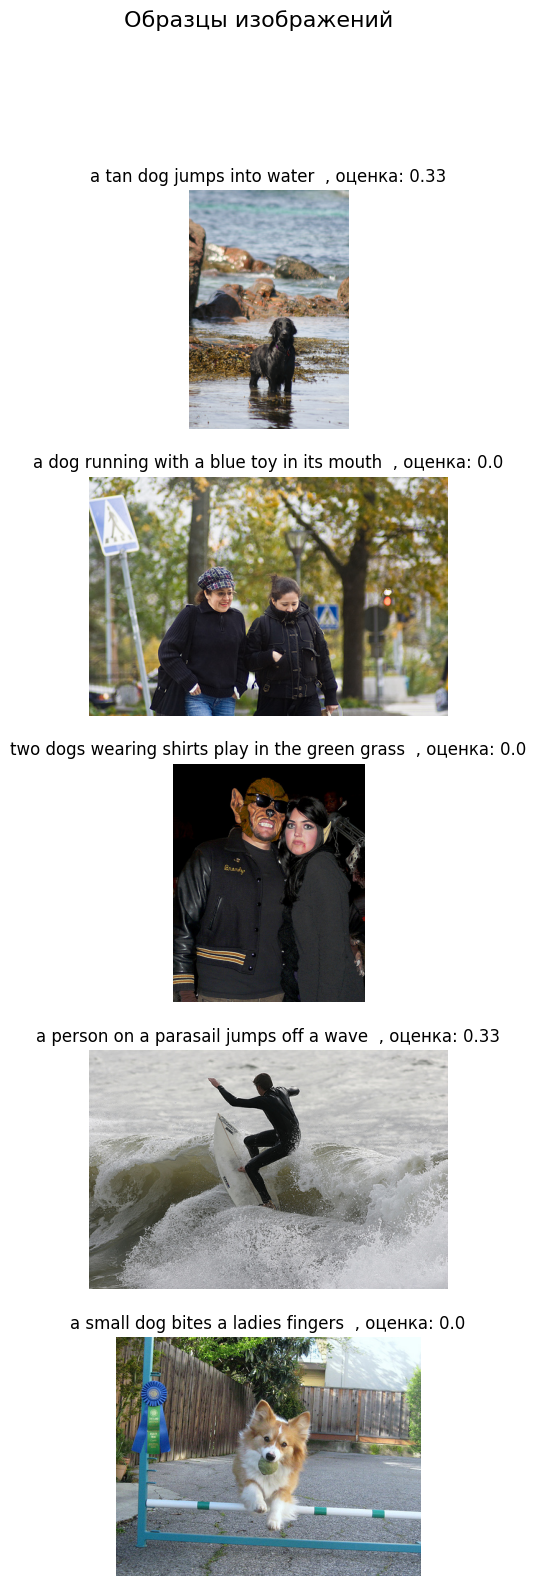

In [60]:
samples_imshow(train, 5, 1)

***Выводы***
* Кол-во оценок экспертов: 2 885
* Кол-во оценок краудсорсинга: 25 808
* Кол-во оценок, после объединения: 27 307

### Тестовые данные

In [61]:
test_df = pd.read_csv('./datasets/test_queries.csv', sep='|', index_col=0)

In [62]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 500 entries, 0 to 499
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   query_id    500 non-null    object
 1   query_text  500 non-null    object
 2   image       500 non-null    object
dtypes: object(3)
memory usage: 15.6+ KB


In [63]:
test_df.head()

query_id  \
0  1177994172_10d143cb8d.jpg#0   
1  1177994172_10d143cb8d.jpg#1   
2  1177994172_10d143cb8d.jpg#2   
3  1177994172_10d143cb8d.jpg#3   
4  1177994172_10d143cb8d.jpg#4   

                                          query_text  \
0  Two blonde boys , one in a camouflage shirt an...   
1  Two boys are squirting water guns at each other .   
2            Two boys spraying each other with water   
3  Two children wearing jeans squirt water at eac...   
4  Two young boys are squirting water at each oth...   

                       image  
0  1177994172_10d143cb8d.jpg  
1  1177994172_10d143cb8d.jpg  
2  1177994172_10d143cb8d.jpg  
3  1177994172_10d143cb8d.jpg  
4  1177994172_10d143cb8d.jpg

In [64]:
test_df.describe().iloc[:2]

query_id query_text image
count       500        500   500
unique      500        500   100

* Каждому изображению применены описания, соответствующие этому изображению.
* Кол-во уникальных изображений - 100, кол-во уникальных описаний - 500. Каждому изображению соответствует ровно пять описаний

Создадим список с именами уникальных изображений

In [65]:
img_test = pd.DataFrame(columns=['img'])

In [66]:
img_test['img'] = test_df['image'].drop_duplicates().reset_index(drop=True)

## Векторизация текстов

Векторизируем тексты с помощью трансформера Bert

In [67]:
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')
bert = TFBertModel.from_pretrained('bert-base-cased')

Some layers from the model checkpoint at bert-base-cased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [68]:
white_list['text_vector'] = white_list.text.progress_apply(
    lambda x: bert(
        tokenizer.encode(x, return_tensors='tf', add_special_tokens=True)
                  )[0][:,0,:][0]
)

100%|██████████| 671/671 [01:21<00:00,  8.20it/s]


In [69]:
white_list.head()

id  \
0  3181701312_70a379ab6e.jpg#2   
1  3207358897_bfa61fa3c6.jpg#2   
2  3286822339_5535af6b93.jpg#2   
3  3360930596_1e75164ce6.jpg#2   
4   434792818_56375e203f.jpg#2   

                                                text  \
0    a man sleeps under a blanket on a city street     
1  a woman plays with long red ribbons in an empt...   
2         chinese market street in the winter time     
3  a soccer ball is above the head of a man weari...   
4  a man and woman look back at the camera while ...   

                  image_name  \
0  3181701312_70a379ab6e.jpg   
1  3207358897_bfa61fa3c6.jpg   
2  3286822339_5535af6b93.jpg   
3  3360930596_1e75164ce6.jpg   
4   434792818_56375e203f.jpg   

                                         text_vector  
0  (tf.Tensor(0.3083228, shape=(), dtype=float32)...  
1  (tf.Tensor(0.20427293, shape=(), dtype=float32...  
2  (tf.Tensor(0.27337235, shape=(), dtype=float32...  
3  (tf.Tensor(-0.0037413966, shape=(), dtype=floa...  
4  (tf.Tensor(0.08543863, shape=(), dtype=float32...

In [70]:
print(f'Размер вектора текста: {white_list.text_vector[0].shape[0]}')

Размер вектора текста: 768


Создадим словарь с векторами описаний

In [71]:
vec_txt = dict(zip(white_list['id'], white_list['text_vector']))

## Векторизация изображений

Векторизируем изображения с помощью сверточной нейросети ResNet-18, предварительно натренированной на датасете ImageNet.

In [72]:
def image_to_array(file: str, path: str = train_path, wh: int = 224, ht: int = 224):
    img = image.load_img(join(path, file), target_size=(wh, ht))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return x

In [73]:
def create_model(input_shape):
    backbone = ResNet50(input_shape=input_shape,
                        weights='imagenet', 
                        include_top=False)
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.compile()

    return model

In [74]:
resnet = create_model((224, 224, 3))

In [75]:
white_list['image_vector'] = white_list.progress_apply(
    lambda x: resnet(image_to_array(x['image_name']))[0], axis=1
)

100%|██████████| 671/671 [01:17<00:00,  8.64it/s]


In [76]:
print(f'Размер вектора изображения: {white_list.image_vector[0].shape[0]}')

Размер вектора изображения: 2048


In [77]:
white_list.image_vector[0].shape

TensorShape([2048])

In [78]:
white_list.head()

id  \
0  3181701312_70a379ab6e.jpg#2   
1  3207358897_bfa61fa3c6.jpg#2   
2  3286822339_5535af6b93.jpg#2   
3  3360930596_1e75164ce6.jpg#2   
4   434792818_56375e203f.jpg#2   

                                                text  \
0    a man sleeps under a blanket on a city street     
1  a woman plays with long red ribbons in an empt...   
2         chinese market street in the winter time     
3  a soccer ball is above the head of a man weari...   
4  a man and woman look back at the camera while ...   

                  image_name  \
0  3181701312_70a379ab6e.jpg   
1  3207358897_bfa61fa3c6.jpg   
2  3286822339_5535af6b93.jpg   
3  3360930596_1e75164ce6.jpg   
4   434792818_56375e203f.jpg   

                                         text_vector  \
0  (tf.Tensor(0.3083228, shape=(), dtype=float32)...   
1  (tf.Tensor(0.20427293, shape=(), dtype=float32...   
2  (tf.Tensor(0.27337235, shape=(), dtype=float32...   
3  (tf.Tensor(-0.0037413966, shape=(), dtype=floa...   
4  (tf.Tensor(0.08543863, shape=(), dtype=float32...   

                                        image_vector  
0  (tf.Tensor(0.3871568, shape=(), dtype=float32)...  
1  (tf.Tensor(0.2776069, shape=(), dtype=float32)...  
2  (tf.Tensor(0.39589503, shape=(), dtype=float32...  
3  (tf.Tensor(0.81888103, shape=(), dtype=float32...  
4  (tf.Tensor(1.0673519, shape=(), dtype=float32)...

Создадим словарь с векторами изображений

In [79]:
vec_img = dict(zip(white_list['image_name'], white_list['image_vector']))

## Объединение векторов

In [80]:
train['vec_img'] = train['image'].map(vec_img).copy()
train['vec_txt'] = train['query_id'].map(vec_txt).copy()
train.insert(3, 'vec_img', train.pop('vec_img'))
train.insert(4, 'vec_txt', train.pop('vec_txt'))

In [81]:
train.head()

image                     query_id  \
26259   534875358_6ea30d3091.jpg  2102360862_264452db8e.jpg#2   
1588   1547883892_e29b3db42e.jpg   421322723_3470543368.jpg#2   
16871  3281078518_630a7a7f4f.jpg  3310067561_b92017acab.jpg#2   
11377  2944836001_b38b516286.jpg  1659358141_0433c9bf99.jpg#2   
24097   405615014_03be7ef618.jpg  2861932486_52befd8592.jpg#2   

                                                    text  \
26259  a man takes a picture of another man at the be...   
1588   a man wearing a green shirt looks down at a ce...   
16871          a dog lies down on a cobblestone street     
11377            a dog running with tongue hanging out     
24097                         a man looking at produce     

                                                 vec_img  \
26259  (tf.Tensor(1.0424927, shape=(), dtype=float32)...   
1588   (tf.Tensor(0.10494591, shape=(), dtype=float32...   
16871  (tf.Tensor(0.037505165, shape=(), dtype=float3...   
11377  (tf.Tensor(1.0852063, shape=(), dtype=float32)...   
24097  (tf.Tensor(0.38609564, shape=(), dtype=float32...   

                                                 vec_txt  estimation  
26259  (tf.Tensor(0.014127469, shape=(), dtype=float3...         0.0  
1588   (tf.Tensor(0.14357007, shape=(), dtype=float32...         0.0  
16871  (tf.Tensor(0.35274023, shape=(), dtype=float32...         0.0  
11377  (tf.Tensor(0.2550365, shape=(), dtype=float32)...         0.0  
24097  (tf.Tensor(0.1867001, shape=(), dtype=float32)...         0.0

In [82]:
train['vec_img_txt'] = train.apply(
    lambda row: tf.concat([row['vec_img'], row['vec_txt']], 0), axis=1
)
train.insert(6, 'vec_img_txt', train.pop('vec_img_txt'))

In [83]:
train.head()

image                     query_id  \
26259   534875358_6ea30d3091.jpg  2102360862_264452db8e.jpg#2   
1588   1547883892_e29b3db42e.jpg   421322723_3470543368.jpg#2   
16871  3281078518_630a7a7f4f.jpg  3310067561_b92017acab.jpg#2   
11377  2944836001_b38b516286.jpg  1659358141_0433c9bf99.jpg#2   
24097   405615014_03be7ef618.jpg  2861932486_52befd8592.jpg#2   

                                                    text  \
26259  a man takes a picture of another man at the be...   
1588   a man wearing a green shirt looks down at a ce...   
16871          a dog lies down on a cobblestone street     
11377            a dog running with tongue hanging out     
24097                         a man looking at produce     

                                                 vec_img  \
26259  (tf.Tensor(1.0424927, shape=(), dtype=float32)...   
1588   (tf.Tensor(0.10494591, shape=(), dtype=float32...   
16871  (tf.Tensor(0.037505165, shape=(), dtype=float3...   
11377  (tf.Tensor(1.0852063, shape=(), dtype=float32)...   
24097  (tf.Tensor(0.38609564, shape=(), dtype=float32...   

                                                 vec_txt  estimation  \
26259  (tf.Tensor(0.014127469, shape=(), dtype=float3...         0.0   
1588   (tf.Tensor(0.14357007, shape=(), dtype=float32...         0.0   
16871  (tf.Tensor(0.35274023, shape=(), dtype=float32...         0.0   
11377  (tf.Tensor(0.2550365, shape=(), dtype=float32)...         0.0   
24097  (tf.Tensor(0.1867001, shape=(), dtype=float32)...         0.0   

                                             vec_img_txt  
26259  (tf.Tensor(1.0424927, shape=(), dtype=float32)...  
1588   (tf.Tensor(0.10494591, shape=(), dtype=float32...  
16871  (tf.Tensor(0.037505165, shape=(), dtype=float3...  
11377  (tf.Tensor(1.0852063, shape=(), dtype=float32)...  
24097  (tf.Tensor(0.38609564, shape=(), dtype=float32...

In [84]:
print(f'Размер объединенного вектора: {train.vec_img_txt[0].shape[0]}')

Размер объединенного вектора: 2816


## Обучение модели предсказания соответствия

### Разбивка данных на выборки

In [85]:
gss = GroupShuffleSplit(n_splits=1, train_size=0.7, random_state=SEED)
train_indices, test_indices = next(gss.split(X=train, groups=train['image']))

In [86]:
print(f'Итоговые размеры выборок, обучающая:тестовая - '
      f'{train_indices.shape[0] / train.shape[0]:.1%}'
      f':{test_indices.shape[0]/ train.shape[0]:.1%}')

Итоговые размеры выборок, обучающая:тестовая - 70.7%:29.3%


In [87]:
X = train['vec_img_txt']
y = train['estimation']

In [88]:
tf_X = tf.stack(X)
tf_X_train = tf.stack(X.iloc[train_indices].values)
tf_X_test = tf.stack(X.iloc[test_indices].values)
y_train = y.iloc[train_indices]
y_test = y.iloc[test_indices]

### Линейная регрессия

In [89]:
table_results = pd.DataFrame(columns=['Name', 'RMSE'])

In [90]:
def results(model, table_results, name):
    predict = model.predict(tf_X_test, verbose=0)
    rmse = round(np.sqrt(mean_squared_error(y_test, predict)), 4)
    print('RMSE на тестовых данных:', rmse)
    return table_results.append(
        {'Name':name, 'RMSE':rmse}, ignore_index=True
    )

В качестве основной метрики будем использовать среднеквадратичную ошибку:
* данная метрика хорошо подходит для регрисионных моделей;
* данная метрика накладывает квадратичный штраф, и следовательно сильно наказывает за большие ошибки, которые для нас неприемлемы;
* показатели имеют размерность исходных данных.

In [91]:
%%time
np.random.seed(SEED)
tf.random.set_seed(SEED)
linear = Sequential()
linear.add(Dense(units=1, input_dim=tf_X_train.shape[1]))
linear.compile(loss='mse', optimizer=Adam(lr=0.0001))
linear.fit(tf_X_train, y_train, validation_data=(tf_X_test, y_test), verbose=2, epochs = 200)

Epoch 1/200
603/603 - 1s - loss: 0.2817 - val_loss: 0.3781 - 745ms/epoch - 1ms/step
Epoch 2/200
603/603 - 0s - loss: 0.1078 - val_loss: 0.3310 - 443ms/epoch - 734us/step
Epoch 3/200
603/603 - 0s - loss: 0.0778 - val_loss: 0.3169 - 428ms/epoch - 710us/step
Epoch 4/200
603/603 - 0s - loss: 0.0681 - val_loss: 0.3121 - 450ms/epoch - 746us/step
Epoch 5/200
603/603 - 0s - loss: 0.0629 - val_loss: 0.3125 - 446ms/epoch - 740us/step
Epoch 6/200
603/603 - 0s - loss: 0.0605 - val_loss: 0.3092 - 428ms/epoch - 710us/step
Epoch 7/200
603/603 - 0s - loss: 0.0597 - val_loss: 0.3118 - 421ms/epoch - 698us/step
Epoch 8/200
603/603 - 0s - loss: 0.0595 - val_loss: 0.3088 - 443ms/epoch - 735us/step
Epoch 9/200
603/603 - 0s - loss: 0.0589 - val_loss: 0.3023 - 456ms/epoch - 757us/step
Epoch 10/200
603/603 - 0s - loss: 0.0590 - val_loss: 0.3027 - 445ms/epoch - 738us/step
Epoch 11/200
603/603 - 0s - loss: 0.0582 - val_loss: 0.3028 - 425ms/epoch - 705us/step
Epoch 12/200
603/603 - 0s - loss: 0.0577 - val_loss: 0

Epoch 96/200
603/603 - 0s - loss: 0.0564 - val_loss: 0.3013 - 435ms/epoch - 722us/step
Epoch 97/200
603/603 - 0s - loss: 0.0556 - val_loss: 0.3024 - 432ms/epoch - 717us/step
Epoch 98/200
603/603 - 0s - loss: 0.0559 - val_loss: 0.3046 - 429ms/epoch - 712us/step
Epoch 99/200
603/603 - 0s - loss: 0.0559 - val_loss: 0.3042 - 440ms/epoch - 729us/step
Epoch 100/200
603/603 - 0s - loss: 0.0560 - val_loss: 0.3040 - 441ms/epoch - 731us/step
Epoch 101/200
603/603 - 0s - loss: 0.0558 - val_loss: 0.3093 - 422ms/epoch - 699us/step
Epoch 102/200
603/603 - 0s - loss: 0.0564 - val_loss: 0.3054 - 437ms/epoch - 725us/step
Epoch 103/200
603/603 - 0s - loss: 0.0563 - val_loss: 0.3039 - 423ms/epoch - 701us/step
Epoch 104/200
603/603 - 0s - loss: 0.0563 - val_loss: 0.3097 - 441ms/epoch - 732us/step
Epoch 105/200
603/603 - 0s - loss: 0.0558 - val_loss: 0.3108 - 431ms/epoch - 716us/step
Epoch 106/200
603/603 - 0s - loss: 0.0560 - val_loss: 0.3103 - 417ms/epoch - 692us/step
Epoch 107/200
603/603 - 0s - loss: 0

603/603 - 0s - loss: 0.0565 - val_loss: 0.3049 - 438ms/epoch - 727us/step
Epoch 190/200
603/603 - 0s - loss: 0.0552 - val_loss: 0.3039 - 439ms/epoch - 728us/step
Epoch 191/200
603/603 - 0s - loss: 0.0554 - val_loss: 0.3021 - 435ms/epoch - 721us/step
Epoch 192/200
603/603 - 0s - loss: 0.0555 - val_loss: 0.3066 - 440ms/epoch - 729us/step
Epoch 193/200
603/603 - 0s - loss: 0.0561 - val_loss: 0.3058 - 412ms/epoch - 684us/step
Epoch 194/200
603/603 - 0s - loss: 0.0552 - val_loss: 0.3070 - 437ms/epoch - 725us/step
Epoch 195/200
603/603 - 0s - loss: 0.0555 - val_loss: 0.3037 - 439ms/epoch - 728us/step
Epoch 196/200
603/603 - 0s - loss: 0.0560 - val_loss: 0.3075 - 438ms/epoch - 727us/step
Epoch 197/200
603/603 - 0s - loss: 0.0553 - val_loss: 0.3088 - 434ms/epoch - 719us/step
Epoch 198/200
603/603 - 0s - loss: 0.0558 - val_loss: 0.3086 - 421ms/epoch - 698us/step
Epoch 199/200
603/603 - 0s - loss: 0.0559 - val_loss: 0.3059 - 447ms/epoch - 741us/step
Epoch 200/200
603/603 - 0s - loss: 0.0558 - va

In [92]:
table_results = results(linear, table_results, 'Линейная регрессия')

RMSE на тестовых данных: 0.5531


### Полносвязная нейронная сеть

In [93]:
%%time
np.random.seed(SEED)
tf.random.set_seed(SEED)
neural = Sequential()
neural.add(Dense(64, input_dim=tf_X_train.shape[1], activation='relu'))
neural.add(Dropout(0.1))
neural.add(Dense(64, activation='relu'))
neural.add(Dropout(0.1))
neural.add(Dense(1, activation='sigmoid'))
neural.compile(loss='mse', optimizer=Adam(lr=0.0001))
neural.fit(
    tf_X_train, y_train, validation_data=(tf_X_test, y_test),
    verbose=2, epochs = 300, workers=16, use_multiprocessing=True
)

Epoch 1/300
603/603 - 1s - loss: 0.0674 - val_loss: 0.0600 - 1s/epoch - 2ms/step
Epoch 2/300
603/603 - 1s - loss: 0.0595 - val_loss: 0.0588 - 759ms/epoch - 1ms/step
Epoch 3/300
603/603 - 1s - loss: 0.0583 - val_loss: 0.0586 - 730ms/epoch - 1ms/step
Epoch 4/300
603/603 - 1s - loss: 0.0577 - val_loss: 0.0581 - 720ms/epoch - 1ms/step
Epoch 5/300
603/603 - 1s - loss: 0.0570 - val_loss: 0.0582 - 721ms/epoch - 1ms/step
Epoch 6/300
603/603 - 1s - loss: 0.0566 - val_loss: 0.0573 - 737ms/epoch - 1ms/step
Epoch 7/300
603/603 - 1s - loss: 0.0559 - val_loss: 0.0576 - 706ms/epoch - 1ms/step
Epoch 8/300
603/603 - 1s - loss: 0.0556 - val_loss: 0.0573 - 721ms/epoch - 1ms/step
Epoch 9/300
603/603 - 1s - loss: 0.0553 - val_loss: 0.0574 - 721ms/epoch - 1ms/step
Epoch 10/300
603/603 - 1s - loss: 0.0543 - val_loss: 0.0580 - 720ms/epoch - 1ms/step
Epoch 11/300
603/603 - 1s - loss: 0.0545 - val_loss: 0.0571 - 737ms/epoch - 1ms/step
Epoch 12/300
603/603 - 1s - loss: 0.0539 - val_loss: 0.0574 - 707ms/epoch - 1

Epoch 98/300
603/603 - 1s - loss: 0.0281 - val_loss: 0.0608 - 744ms/epoch - 1ms/step
Epoch 99/300
603/603 - 1s - loss: 0.0280 - val_loss: 0.0647 - 736ms/epoch - 1ms/step
Epoch 100/300
603/603 - 1s - loss: 0.0270 - val_loss: 0.0603 - 754ms/epoch - 1ms/step
Epoch 101/300
603/603 - 1s - loss: 0.0272 - val_loss: 0.0617 - 777ms/epoch - 1ms/step
Epoch 102/300
603/603 - 1s - loss: 0.0276 - val_loss: 0.0598 - 742ms/epoch - 1ms/step
Epoch 103/300
603/603 - 1s - loss: 0.0270 - val_loss: 0.0602 - 737ms/epoch - 1ms/step
Epoch 104/300
603/603 - 1s - loss: 0.0269 - val_loss: 0.0604 - 737ms/epoch - 1ms/step
Epoch 105/300
603/603 - 1s - loss: 0.0274 - val_loss: 0.0611 - 737ms/epoch - 1ms/step
Epoch 106/300
603/603 - 1s - loss: 0.0270 - val_loss: 0.0599 - 768ms/epoch - 1ms/step
Epoch 107/300
603/603 - 1s - loss: 0.0270 - val_loss: 0.0619 - 738ms/epoch - 1ms/step
Epoch 108/300
603/603 - 1s - loss: 0.0266 - val_loss: 0.0597 - 752ms/epoch - 1ms/step
Epoch 109/300
603/603 - 1s - loss: 0.0270 - val_loss: 0.

Epoch 194/300
603/603 - 1s - loss: 0.0198 - val_loss: 0.0619 - 736ms/epoch - 1ms/step
Epoch 195/300
603/603 - 1s - loss: 0.0200 - val_loss: 0.0604 - 738ms/epoch - 1ms/step
Epoch 196/300
603/603 - 1s - loss: 0.0201 - val_loss: 0.0601 - 737ms/epoch - 1ms/step
Epoch 197/300
603/603 - 1s - loss: 0.0201 - val_loss: 0.0595 - 759ms/epoch - 1ms/step
Epoch 198/300
603/603 - 1s - loss: 0.0197 - val_loss: 0.0623 - 767ms/epoch - 1ms/step
Epoch 199/300
603/603 - 1s - loss: 0.0200 - val_loss: 0.0608 - 766ms/epoch - 1ms/step
Epoch 200/300
603/603 - 1s - loss: 0.0194 - val_loss: 0.0598 - 766ms/epoch - 1ms/step
Epoch 201/300
603/603 - 1s - loss: 0.0201 - val_loss: 0.0610 - 773ms/epoch - 1ms/step
Epoch 202/300
603/603 - 1s - loss: 0.0199 - val_loss: 0.0596 - 745ms/epoch - 1ms/step
Epoch 203/300
603/603 - 1s - loss: 0.0194 - val_loss: 0.0599 - 753ms/epoch - 1ms/step
Epoch 204/300
603/603 - 1s - loss: 0.0198 - val_loss: 0.0597 - 752ms/epoch - 1ms/step
Epoch 205/300
603/603 - 1s - loss: 0.0195 - val_loss: 

Epoch 290/300
603/603 - 1s - loss: 0.0170 - val_loss: 0.0592 - 753ms/epoch - 1ms/step
Epoch 291/300
603/603 - 1s - loss: 0.0169 - val_loss: 0.0588 - 743ms/epoch - 1ms/step
Epoch 292/300
603/603 - 1s - loss: 0.0174 - val_loss: 0.0599 - 754ms/epoch - 1ms/step
Epoch 293/300
603/603 - 1s - loss: 0.0168 - val_loss: 0.0589 - 817ms/epoch - 1ms/step
Epoch 294/300
603/603 - 1s - loss: 0.0169 - val_loss: 0.0578 - 766ms/epoch - 1ms/step
Epoch 295/300
603/603 - 1s - loss: 0.0170 - val_loss: 0.0611 - 759ms/epoch - 1ms/step
Epoch 296/300
603/603 - 1s - loss: 0.0175 - val_loss: 0.0611 - 769ms/epoch - 1ms/step
Epoch 297/300
603/603 - 1s - loss: 0.0170 - val_loss: 0.0593 - 777ms/epoch - 1ms/step
Epoch 298/300
603/603 - 1s - loss: 0.0166 - val_loss: 0.0591 - 735ms/epoch - 1ms/step
Epoch 299/300
603/603 - 1s - loss: 0.0172 - val_loss: 0.0597 - 737ms/epoch - 1ms/step
Epoch 300/300
603/603 - 1s - loss: 0.0165 - val_loss: 0.0595 - 754ms/epoch - 1ms/step
CPU times: total: 13min
Wall time: 3min 44s


In [94]:
table_results = results(neural, table_results, 'Полносвязная нейронная сеть')

RMSE на тестовых данных: 0.244


### Сравнение моделей

In [95]:
table_results

Name    RMSE
0           Линейная регрессия  0.5531
1  Полносвязная нейронная сеть  0.2440

* Лучший результат показала модель полносвязной нейронной сети - 0.2440.

###  Полносвязная нейронная сеть на полных данных

In [96]:
%%time
np.random.seed(SEED)
tf.random.set_seed(SEED)
neural = Sequential()
neural.add(Dense(64, input_dim=tf_X.shape[1], activation='relu'))
neural.add(Dropout(0.1))
neural.add(Dense(64, activation='relu'))
neural.add(Dropout(0.1))
neural.add(Dense(1, activation='sigmoid'))
neural.compile(loss='mse', optimizer=Adam(lr=0.0001))
neural.fit(tf_X, y, verbose=2, epochs = 300, workers=16, use_multiprocessing=True)

Epoch 1/300
854/854 - 1s - loss: 0.0610 - 1s/epoch - 1ms/step
Epoch 2/300
854/854 - 1s - loss: 0.0584 - 1s/epoch - 1ms/step
Epoch 3/300
854/854 - 1s - loss: 0.0574 - 988ms/epoch - 1ms/step
Epoch 4/300
854/854 - 1s - loss: 0.0567 - 888ms/epoch - 1ms/step
Epoch 5/300
854/854 - 1s - loss: 0.0561 - 822ms/epoch - 963us/step
Epoch 6/300
854/854 - 1s - loss: 0.0553 - 802ms/epoch - 939us/step
Epoch 7/300
854/854 - 1s - loss: 0.0545 - 812ms/epoch - 951us/step
Epoch 8/300
854/854 - 1s - loss: 0.0541 - 972ms/epoch - 1ms/step
Epoch 9/300
854/854 - 1s - loss: 0.0530 - 972ms/epoch - 1ms/step
Epoch 10/300
854/854 - 1s - loss: 0.0525 - 988ms/epoch - 1ms/step
Epoch 11/300
854/854 - 1s - loss: 0.0521 - 1s/epoch - 1ms/step
Epoch 12/300
854/854 - 1s - loss: 0.0512 - 936ms/epoch - 1ms/step
Epoch 13/300
854/854 - 1s - loss: 0.0506 - 815ms/epoch - 954us/step
Epoch 14/300
854/854 - 1s - loss: 0.0498 - 996ms/epoch - 1ms/step
Epoch 15/300
854/854 - 1s - loss: 0.0494 - 983ms/epoch - 1ms/step
Epoch 16/300
854/854

854/854 - 1s - loss: 0.0219 - 972ms/epoch - 1ms/step
Epoch 127/300
854/854 - 1s - loss: 0.0216 - 1s/epoch - 1ms/step
Epoch 128/300
854/854 - 1s - loss: 0.0217 - 955ms/epoch - 1ms/step
Epoch 129/300
854/854 - 1s - loss: 0.0211 - 974ms/epoch - 1ms/step
Epoch 130/300
854/854 - 1s - loss: 0.0210 - 1s/epoch - 1ms/step
Epoch 131/300
854/854 - 1s - loss: 0.0210 - 984ms/epoch - 1ms/step
Epoch 132/300
854/854 - 1s - loss: 0.0209 - 943ms/epoch - 1ms/step
Epoch 133/300
854/854 - 1s - loss: 0.0210 - 973ms/epoch - 1ms/step
Epoch 134/300
854/854 - 1s - loss: 0.0215 - 988ms/epoch - 1ms/step
Epoch 135/300
854/854 - 1s - loss: 0.0209 - 997ms/epoch - 1ms/step
Epoch 136/300
854/854 - 1s - loss: 0.0208 - 978ms/epoch - 1ms/step
Epoch 137/300
854/854 - 1s - loss: 0.0205 - 989ms/epoch - 1ms/step
Epoch 138/300
854/854 - 1s - loss: 0.0205 - 815ms/epoch - 955us/step
Epoch 139/300
854/854 - 1s - loss: 0.0214 - 802ms/epoch - 939us/step
Epoch 140/300
854/854 - 1s - loss: 0.0211 - 891ms/epoch - 1ms/step
Epoch 141/3

Epoch 250/300
854/854 - 1s - loss: 0.0163 - 991ms/epoch - 1ms/step
Epoch 251/300
854/854 - 1s - loss: 0.0161 - 1s/epoch - 1ms/step
Epoch 252/300
854/854 - 1s - loss: 0.0161 - 988ms/epoch - 1ms/step
Epoch 253/300
854/854 - 1s - loss: 0.0162 - 969ms/epoch - 1ms/step
Epoch 254/300
854/854 - 1s - loss: 0.0165 - 958ms/epoch - 1ms/step
Epoch 255/300
854/854 - 1s - loss: 0.0163 - 815ms/epoch - 954us/step
Epoch 256/300
854/854 - 1s - loss: 0.0162 - 877ms/epoch - 1ms/step
Epoch 257/300
854/854 - 1s - loss: 0.0160 - 818ms/epoch - 957us/step
Epoch 258/300
854/854 - 1s - loss: 0.0160 - 924ms/epoch - 1ms/step
Epoch 259/300
854/854 - 1s - loss: 0.0160 - 833ms/epoch - 975us/step
Epoch 260/300
854/854 - 1s - loss: 0.0156 - 829ms/epoch - 971us/step
Epoch 261/300
854/854 - 1s - loss: 0.0160 - 800ms/epoch - 937us/step
Epoch 262/300
854/854 - 1s - loss: 0.0164 - 942ms/epoch - 1ms/step
Epoch 263/300
854/854 - 1s - loss: 0.0154 - 807ms/epoch - 945us/step
Epoch 264/300
854/854 - 1s - loss: 0.0157 - 816ms/epo

## Тестирование модели

Векторизируем тестовые изображения

In [97]:
img_test['img_vec'] = img_test.progress_apply(
    lambda x: resnet(image_to_array(x['img'], test_path))[0], axis=1
)

100%|██████████| 100/100 [00:12<00:00,  7.85it/s]


In [98]:
img_test.head()

img  \
0  1177994172_10d143cb8d.jpg   
1  1232148178_4f45cc3284.jpg   
2   123997871_6a9ca987b1.jpg   
3  1319634306_816f21677f.jpg   
4  1429546659_44cb09cbe2.jpg   

                                             img_vec  
0  (tf.Tensor(0.2721748, shape=(), dtype=float32)...  
1  (tf.Tensor(0.27630237, shape=(), dtype=float32...  
2  (tf.Tensor(0.38630667, shape=(), dtype=float32...  
3  (tf.Tensor(0.21799529, shape=(), dtype=float32...  
4  (tf.Tensor(0.15964335, shape=(), dtype=float32...

Функция поиска релевантных изображений

In [99]:
def relevant_img(text, df_img, model):
    if check_stop(text):
        return print(
            f'{style.BOLD}'
            f'This image is unavailable in your country in compliance with local laws.'
            f'{style.END}'
        )
    # Векторизация текстового запроса
    txt_vec = bert(
        tokenizer.encode(text, return_tensors='tf', add_special_tokens=True)
    )[0][:,0,:][0]
    
    # Объединение векторов изображений с вектором текста
    df_img['vec_img_txt'] = df_img.apply(
        lambda row: tf.concat([row['img_vec'], txt_vec], 0), axis=1
    )
    
    # Получение прогнозов модели
    X = tf.stack(df_img['vec_img_txt'])
    predict = model.predict(X, verbose=0)
    df_img['estimation'] = predict
    
    # Поиск лучшего изображения и вывод его на экран    
    best_img = df_img.loc[df_img['estimation'].idxmax()]
    img = Image.open(join(test_path, best_img['img']))
    plt.imshow(img)
    plt.title(f'{text}, Метрика качества:{best_img.estimation:.4f}')
    plt.axis('off')
    plt.show()   

Выведем 10 случайных запросов

This image is unavailable in your country in compliance with local laws.


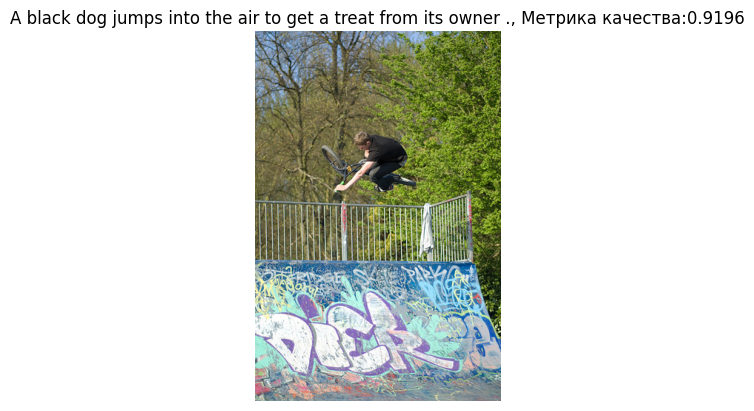

This image is unavailable in your country in compliance with local laws.


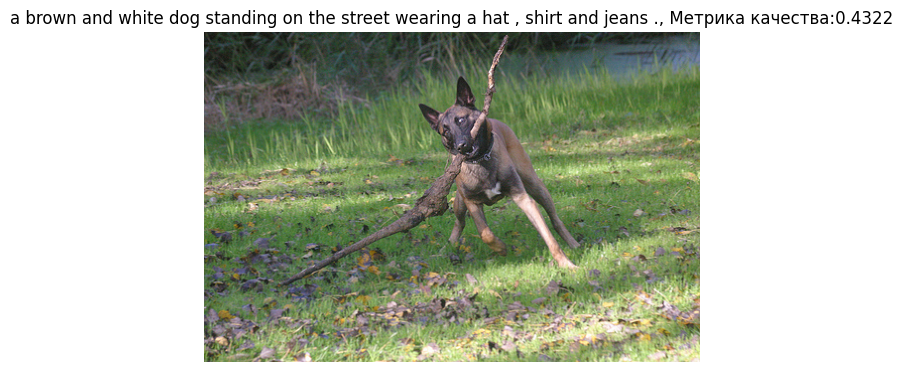

This image is unavailable in your country in compliance with local laws.
This image is unavailable in your country in compliance with local laws.
This image is unavailable in your country in compliance with local laws.


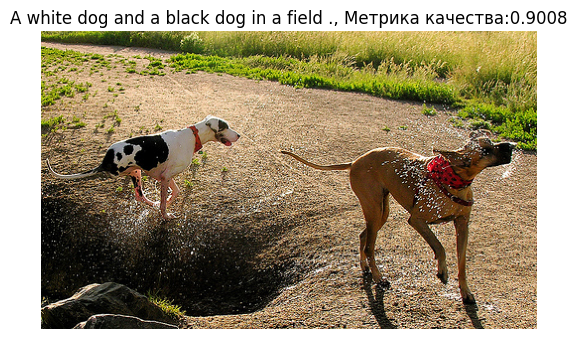

This image is unavailable in your country in compliance with local laws.
This image is unavailable in your country in compliance with local laws.


In [100]:
for i in range(10):
    random_index = np.random.randint(0, (test_df.shape[0] - 1))
    relevant_img(test_df.query_text[random_index], img_test, neural)

* Модель угадывает действующие лица или основное действия, но точность сопоставлений, оставляет желать лучшего.

## Нейронная сеть CLIP 

Векторизируем изображения

In [101]:
#Load CLIP model
clip = SentenceTransformer('clip-ViT-B-32')

ftfy or spacy is not installed using BERT BasicTokenizer instead of ftfy.


In [102]:
img_clip = img_test[['img']].copy()

In [103]:
img_clip['img_vec'] = img_clip.img.progress_apply(
    lambda x: clip.encode(Image.open(join(test_path, x)))
)

100%|██████████| 100/100 [00:08<00:00, 11.89it/s]


Функция поиска релевантных изображений

In [104]:
def relevant_img_clip(text, df_img):
    if check_stop(text):
        return print(
            f'{style.BOLD}'
            f'This image is unavailable in your country in compliance with local laws.'
            f'{style.END}'
        )
    # Векторизация текстового запроса
    txt_vec = clip.encode(text)
    
    # Получение прогнозов модели
    df_img['estimation'] = img_clip.img_vec.apply(
    lambda x: util.cos_sim(x, txt_vec).item()
    )
    
    # Поиск лучшего изображения и вывод его на экран    
    best_img = df_img.loc[df_img['estimation'].idxmax()]
    img = Image.open(join(test_path, best_img['img']))
    plt.imshow(img)
    plt.title(f'{text}, Метрика качества:{best_img.estimation:.4f}')
    plt.axis('off')
    plt.show()  

Выведем 10 случайных запросов

This image is unavailable in your country in compliance with local laws.


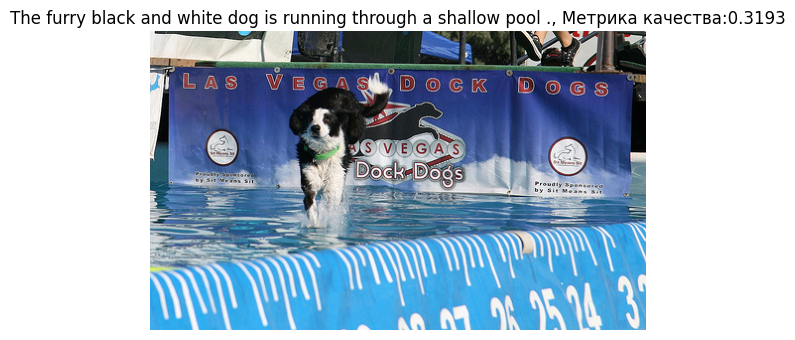

This image is unavailable in your country in compliance with local laws.


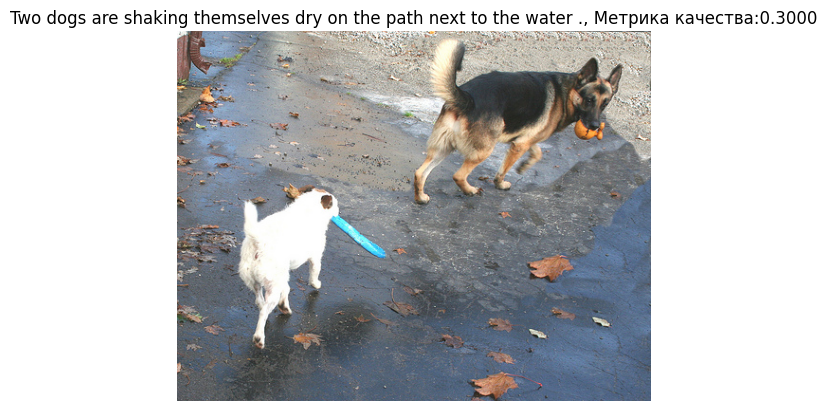

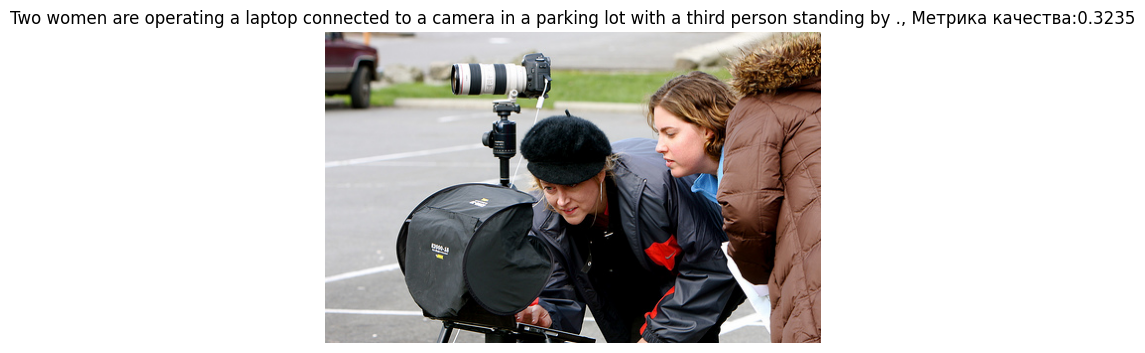

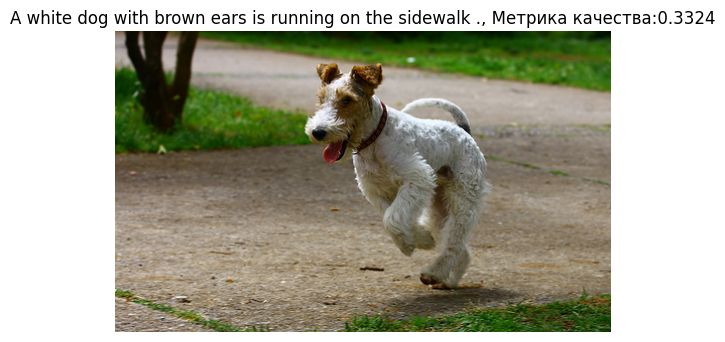

This image is unavailable in your country in compliance with local laws.


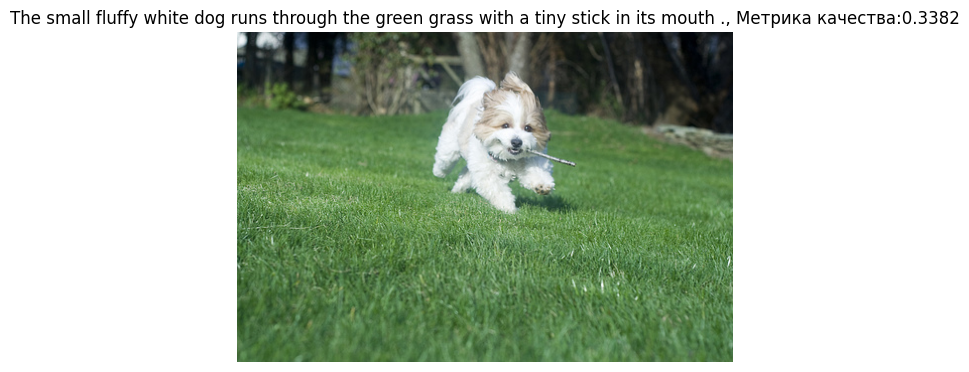

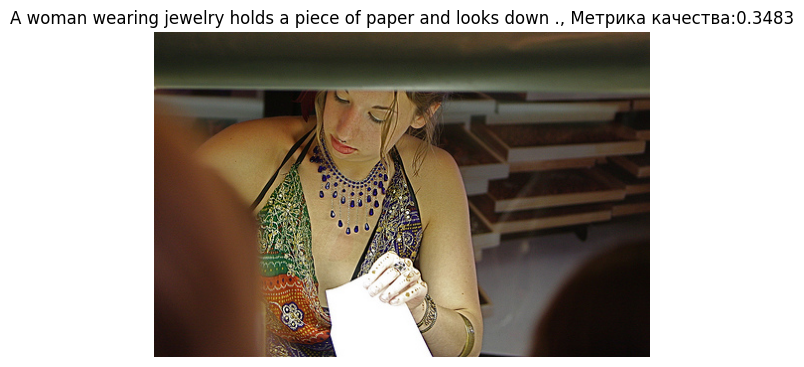

This image is unavailable in your country in compliance with local laws.


In [105]:
for i in range(10):
    random_index = np.random.randint(0, (test_df.shape[0] - 1))
    relevant_img_clip(test_df.query_text[random_index], img_clip)

* Модель отлично справилась со всеми запросами, полное попадание.

## Выводы

In [106]:
table_results

Name    RMSE
0           Линейная регрессия  0.5531
1  Полносвязная нейронная сеть  0.2440

* Лучший результат показала модель полносвязной нейронной сети - 0.244;
* Модель угадывает действующие лица или основное действия, но точность сопоставлений, оставляет желать лучшего;
* Для улучшение модели можно увеличить размер тренировочной выборки и улучшить качество разметки данных;
* Была опробованна нейронная сеть CLIP от OPEN AI, модель отлично справляется с сопоставлением картинок и текса. 